<table width="100%" border="3">
  <tbody>
    <tr>
      <td ><img src="https://aidea-web.tw/images/web/logo_white.png" alt="Aidea" width="400"/></td>
      <td align='left'><h1>Exercise 3:Prediction with holidays</h1></td>
    </tr>
  </tbody>
</table>
Taxi Hotspot Prediction with holidays

In [1]:
from google_drive_downloader import GoogleDriveDownloader
GoogleDriveDownloader.download_file_from_google_drive(file_id='13BhHdMYUP7VxYV1PNoQGx-wldEMebjyd',dest_path='./content', unzip=True)

Unzipping...Done.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Read training data
df_train = pd.read_csv('taxi_data/train_hire_stats.csv')
df_train.shape

(219600, 4)

In [4]:
#Check weekday & workday
#holidays連假的平常日
#workdays連假的補班日
holidays=set(['2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12','2016-02-29', '2016-04-04', '2016-04-05', '2016-06-09', '2016-06-10', 
'2016-09-15', '2016-09-16', '2016-10-10', '2017-01-02', '2017-01-27', '2017-01-30', '2017-02-01','2017-02-27', '2017-02-28'])
makeupworkdays = set(['2016-06-04', '2016-09-10', '2017-02-18'])

In [5]:
#Declare weekday & workday
isworkday = np.ones((len(df_train),), dtype=int)
weekday = np.ones((len(df_train),), dtype=int)

In [6]:
#Compute weekday & workday
#weekday()
#0 == Monday, #1 == Tuesday, #2 == Wednesday,  #3 == Thursday,  #4 == Friday,  #5 == Saturday, #6 == Sunday
from datetime import datetime

for index, row in df_train.iterrows():
    if row['Date'] in holidays:
        isworkday[index] = 0
    else:
        dd=datetime.strptime(row['Date'], "%Y-%m-%d")
        weekday[index]= dd.weekday() 
        if weekday[index] >=5 and row['Date'] not in makeupworkdays:
            isworkday[index] = 0


In [7]:
#Build a new dataframe from the training data
RawX = pd.DataFrame(df_train[["Zone_ID", "Hour_slot"]])
RawX['isworkday'] = isworkday
RawX['weekday'] = weekday

In [8]:
#See the raw input data
RawX.head()

,Zone_ID,Hour_slot,isworkday,weekday
0,1,0,1,0
1,1,1,1,0
2,1,2,1,0
3,1,3,1,0
4,1,4,1,0


In [9]:
#Use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

In [10]:
#Build encoder
enc.fit_transform(RawX)
enc.categories_

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23], dtype=int64),
 array([0, 1]),
 array([0, 1, 2, 3, 4, 5, 6])]

In [11]:
#Transform data into one hot vector
X = enc.transform(RawX).toarray()
X.shape

(219600, 58)

In [12]:
#See the cooked input data
X[0:3, :]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]])

In [13]:
#Resize y into (0,1)
y = df_train["Hire_count"].values/339.0
y.shape

(219600,)

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout

In [15]:
# create and fit a Baseline Neural Network Model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=58))
model.add(Dense(units=10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

In [16]:
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, epochs=10, batch_size=1024, verbose=1)

Epoch 1/10
215/215 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 2/10
215/215 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 3/10
215/215 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 4/10
215/215 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 5/10
215/215 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 6/10
215/215 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 7/10
215/215 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 8/10
215/215 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 9/10
215/215 [==============================] - 0s 2ms/step - loss: 9.9378e-04
Epoch 10/10
215/215 [==============================] - 0s 2ms/step - loss: 0.0010


In [17]:
df_test = pd.read_csv('taxi_data/test_hire_stats.csv')
df_test.shape

(6048, 5)

In [18]:
#Declare weekday & workday
isworkday2 = np.ones((len(df_test),), dtype=int)
weekday2 = np.ones((len(df_test),), dtype=int)

In [19]:
for index, row in df_test.iterrows():
    if row['Date'] in holidays:
        isworkday2[index] = 0
    else:
        dd=datetime.strptime(row['Date'], "%Y-%m-%d")
        weekday2[index]= dd.weekday() 
        if weekday2[index] >=5 and row['Date'] not in makeupworkdays:
            isworkday2[index] = 0

In [20]:
Test = pd.DataFrame(df_test[["Zone_ID", "Hour_slot"]])
Test['isworkday'] = isworkday2
Test['weekday'] = weekday2

In [21]:
Xtest = enc.transform(Test).toarray()
Xtest.shape

(6048, 58)

In [22]:
yt = model.predict(Xtest)*339.0

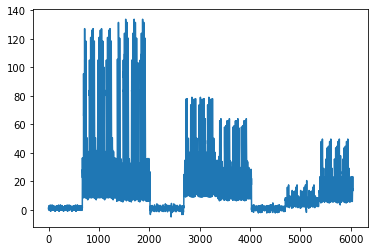

In [23]:
plt.plot(yt)

In [24]:
dfOut = pd.DataFrame(yt)

In [25]:
dfOut.to_csv('Result3.csv')